In [ ]:
! pip install -q kaggle

In [ ]:
import json
 
# Data to be written
dictionary = {
    "username":"kshitijazad",
    "key":"e3b75cd138d2d23cd85cc9acc87f84e6"
    }
 
# Serializing json
json_object = json.dumps(dictionary, indent=4)
 
# Writing to sample.json
with open("kaggle.json", "w") as outfile:
    outfile.write(json_object)

In [ ]:
!rm ~/.kaggle/kaggle.json
!rmdir ~/.kaggle

rm: cannot remove '/root/.kaggle/kaggle.json': No such file or directory
rmdir: failed to remove '/root/.kaggle': No such file or directory


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d brjapon/gearbox-fault-diagnosis

 82% 25.0M/30.5M [00:01<00:00, 22.9MB/s]
100% 30.5M/30.5M [00:01<00:00, 25.2MB/s]


In [ ]:
! mkdir train

In [ ]:
! unzip gearbox-fault-diagnosis.zip -d train

Archive:  gearbox-fault-diagnosis.zip
  inflating: train/BrokenTooth/b30hz0.csv  
  inflating: train/BrokenTooth/b30hz10.csv  
  inflating: train/BrokenTooth/b30hz20.csv  
  inflating: train/BrokenTooth/b30hz30.csv  
  inflating: train/BrokenTooth/b30hz40.csv  
  inflating: train/BrokenTooth/b30hz50.csv  
  inflating: train/BrokenTooth/b30hz60.csv  
  inflating: train/BrokenTooth/b30hz70.csv  
  inflating: train/BrokenTooth/b30hz80.csv  
  inflating: train/BrokenTooth/b30hz90.csv  
  inflating: train/Healthy/h30hz0.csv  
  inflating: train/Healthy/h30hz10.csv  
  inflating: train/Healthy/h30hz20.csv  
  inflating: train/Healthy/h30hz30.csv  
  inflating: train/Healthy/h30hz40.csv  
  inflating: train/Healthy/h30hz50.csv  
  inflating: train/Healthy/h30hz60.csv  
  inflating: train/Healthy/h30hz70.csv  
  inflating: train/Healthy/h30hz80.csv  
  inflating: train/Healthy/h30hz90.csv  


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import fft, signal, stats
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict as dd
import os

In [ ]:
dfs = []
for dirname, _, filenames in tqdm(os.walk('/content/train')):
    for filename in tqdm(filenames, leave=False):
        
        # the gearbox state is in the filename prefix (h = healthy, b = broken tooth)
        state = filename[0]
        
        # the load is in the filename suffix
        load = int(filename.split('.')[0][5:])
        
        # read in the file
        df = pd.read_csv(os.path.join(dirname, filename))
        
        # include the healthy/broken state
        df['state'] = state
        
        # include the load
        df['load'] = load
        
        # append to a list
        dfs.append(df)

# concatenate all the datasets and reset the index
df = pd.concat(dfs).reset_index().rename(columns={'index':'sample_index'})

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
df

In [ ]:
df.sample(3, random_state=42)

In [ ]:
sensor_readings = df.melt(
    id_vars=['sample_index','state','load'],
    value_vars=['a1','a2','a3','a4'],
    var_name='sensor',
    value_name='reading'
)

In [ ]:
sns.countplot(
    data=sensor_readings[sensor_readings.sensor=='a1'],
    y='load',
    hue='state',
)

In [ ]:
# Which set has the lowest number of samples
lowest_samples = df.groupby(['state','load']).sample_index.count().min()
print(f'Lowest number of samples = {lowest_samples}')
print(f'Translates to {lowest_samples/30:0.2f} seconds or {lowest_samples/30/60:0.2f} minutes')

In [ ]:
# helper function to filter the dataset
def rdg(df, state=None, load=None, sensor=None):
    df_st = df[df.state==state] if state is not None else df
    df_lo = df_st[df_st.load==load] if load is not None else df_st
    df_se = df_lo[df_lo.sensor==sensor] if sensor is not None else df_lo
    return df_se

In [ ]:
g = sns.FacetGrid(
    data=pd.concat([
        rdg(sensor_readings, load=0, sensor='a1'),
        rdg(sensor_readings, load=90, sensor='a1')
    ]),
    col='load',
    row='state',
    height=2.5,
    aspect=2.5
)
g.map(plt.plot, 'reading')
plt.show()

In [ ]:
print('Each row is a different sensor, each column is increasing load')
print('Each plot shows the distribution of reading values between the healthy and broken gearbox')
sns.catplot(
    data=sensor_readings,
    col='load', row='sensor',
    x='state', y='reading',
    kind='boxen',
    height=10
)

In [ ]:
plt.figure(figsize=(13,5))
sns.histplot(
    data=sensor_readings,
    hue='state',
    x='reading',
)
plt.show()

In [ ]:
display(sensor_readings.groupby(['sensor','state']).reading.std().unstack())
print(f"Standard deviation including sensor a1: {sensor_readings.reading.std()}")
print(f"Standard deviation excluding sensor a1: {sensor_readings[sensor_readings.sensor!='a1'].reading.std()}")

state,b,h
sensor,,
a1,4.602696,7.381206
a2,4.389516,4.427153
a3,3.808909,4.110277
a4,4.408367,4.523553


Standard deviation including sensor a1: 4.822152445519274
Standard deviation excluding sensor a1: 4.285349925978814


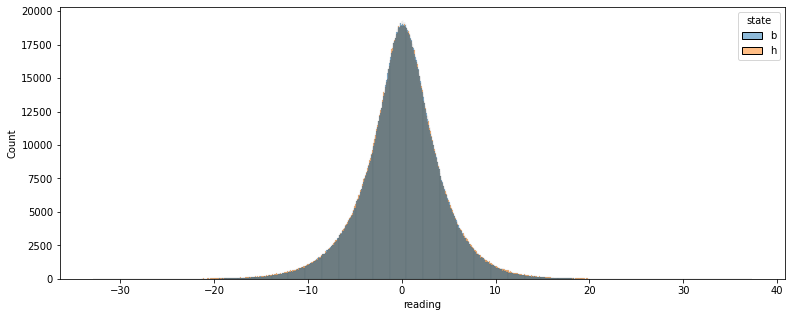

In [ ]:
# drop readings from sensor a1
readings = sensor_readings[sensor_readings.sensor!='a1']
plt.figure(figsize=(13,5))
sns.histplot(
    data=readings,
    hue='state',
    x='reading',
)
plt.show()


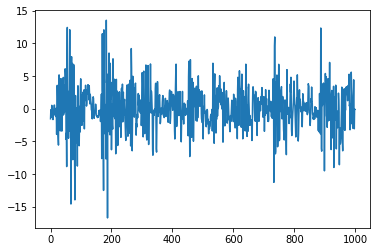

In [ ]:
x = rdg(sensor_readings, 'h', 10, 'a4').reading.values[:1000]
plt.plot(x)
plt.show()

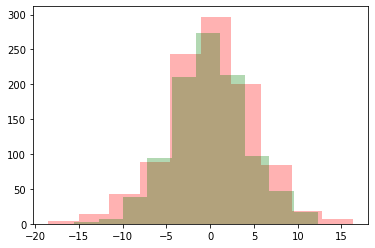

In [ ]:
plt.hist(rdg(sensor_readings, 'b', 90, 'a2').reading.values[:1000], color='r', alpha=0.3) # broken tooth
plt.hist(rdg(sensor_readings, 'h', 90, 'a2').reading.values[:1000], color='g', alpha=0.3) # healthy
plt.show()

In [ ]:
data = []
labels = []
for (state,load,sensor),g in sensor_readings.groupby(['state','load','sensor']):
    vals = g.reading.values
    splits = np.split(vals, range(1000,vals.shape[0],1000))
    for s in splits[:-1]:  # except the last one
        data.append({
            'sensor_a1': int(sensor=='a1'),
            'sensor_a2': int(sensor=='a2'),
            'sensor_a3': int(sensor=='a3'),
            # no need to put a4: if a1-3 are 0, then it's sensor a4
            'load': load,
            'mean': np.mean(s),
            'std': np.std(s),
            'kurt': stats.kurtosis(s),
            'skew': stats.skew(s),
            'moment': stats.moment(s),
        })
        labels.append(int(state=='b'))  # positive label indicates fault

df_data = pd.DataFrame(data)
data = df_data.values
labels = np.array(labels)
(data.shape, labels.shape)

((8036, 9), (8036,))

In [ ]:
print(f'Total samples: {len(labels)}')
print(f'Fault class: {np.sum(labels)} ({np.sum(labels)/len(labels):0.1%})')

Total samples: 8036
Fault class: 4000 (49.8%)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data, labels,
    train_size=0.8,
    random_state=42,
    stratify=labels
)
print(f'Training data: {X_train.shape}')
print(f'Test data: {X_test.shape}')

Training data: (6428, 9)
Test data: (1608, 9)


In [ ]:
!pip install tpot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 3.0 MB/s 
     |████████████████████████████████| 255.9 MB 48 kB/s 
     |████████████████████████████████| 139 kB 45.3 MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11956 sha256=079c7fd2c2ad074da082d562bac1594e21587469e4e5dc7859e7cd3457670f0c
  Stored in directory: /root/.cache/pip/wheels/e2/d2/79/eaf81edb391e27c87f51b8ef901ecc85a5363dc96b8b8d71e3
Successfully built stopit
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
from tpot import TPOTClassifier

In [ ]:
%%time
tpot_td = TPOTClassifier(generations=5, random_state=42, max_time_mins=2)
tpot_td.fit(X_train, y_train)
print(f'Best accuracy score: {tpot_td.score(X_test, y_test):0.3%}')

Best accuracy score: 86.381%
CPU times: user 2min 11s, sys: 47.4 s, total: 2min 59s
Wall time: 2min 9s


In [ ]:
pd.Series([
    model.split('(')[0]
    for model
    in tpot_td.evaluated_individuals_.keys()
]).value_counts()

MLPClassifier                 6
ExtraTreesClassifier          5
XGBClassifier                 4
RandomForestClassifier        2
KNeighborsClassifier          2
BernoulliNB                   2
GaussianNB                    1
DecisionTreeClassifier        1
GradientBoostingClassifier    1
SGDClassifier                 1
dtype: int64

In [ ]:
sensor_data = rdg(sensor_readings, 'h', 10, 'a4').reading.values

46465 total number of frequency points


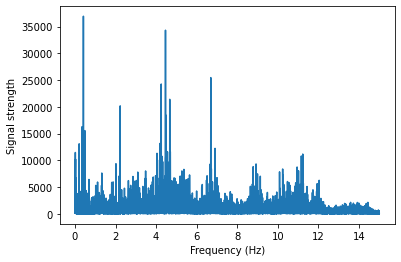

In [ ]:
y = np.abs(fft.rfft(sensor_data))
x = fft.rfftfreq(sensor_data.shape[0], 1/30)  # 30Hz data rate
print(f"{y.shape[0]} total number of frequency points")

plt.plot(x, y)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Signal strength')
plt.show()

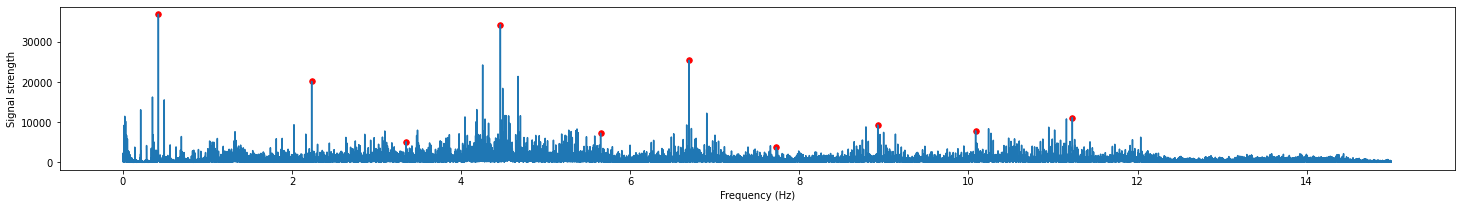

In [ ]:
y = np.abs(fft.rfft(sensor_data))
x = fft.rfftfreq(sensor_data.shape[0], 1/30)  # 30Hz data rate

fig, ax = plt.subplots(figsize=(25,3))
ax.plot(x, y)

# find peaks that are
#   at least 1Hz apart (number of frequency points / max frequency)
x_peak_spacing = y.shape[0] / x.max()
#   rising above surrounding values by the 99th percentile of the values
x_peak_prominence = np.quantile(y,0.99)

peaks, _ = signal.find_peaks(y, distance=x_peak_spacing, prominence=x_peak_prominence)

for peak in peaks:
    ax.scatter(x=x[peak], y=y[peak], c='r', marker='o', s=30)

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Signal strength')
plt.show()

In [ ]:
[x[peak] for peak in peaks]

[0.41838842975206614,
 2.2317277892561984,
 3.347753099173554,
 4.463455578512397,
 5.64921229338843,
 6.695506198347108,
 7.72759555785124,
 8.927233987603307,
 10.08490444214876,
 11.228693181818182]

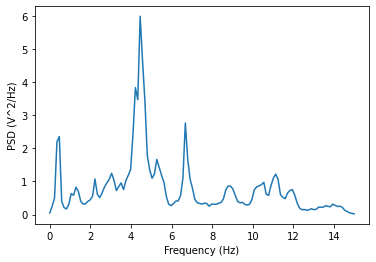

In [ ]:
x, y = signal.welch(sensor_data, fs=30) # 30Hz data rate
plt.plot(x, y)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V^2/Hz)')
plt.show()

  0%|          | 0/40 [00:00<?, ?it/s]

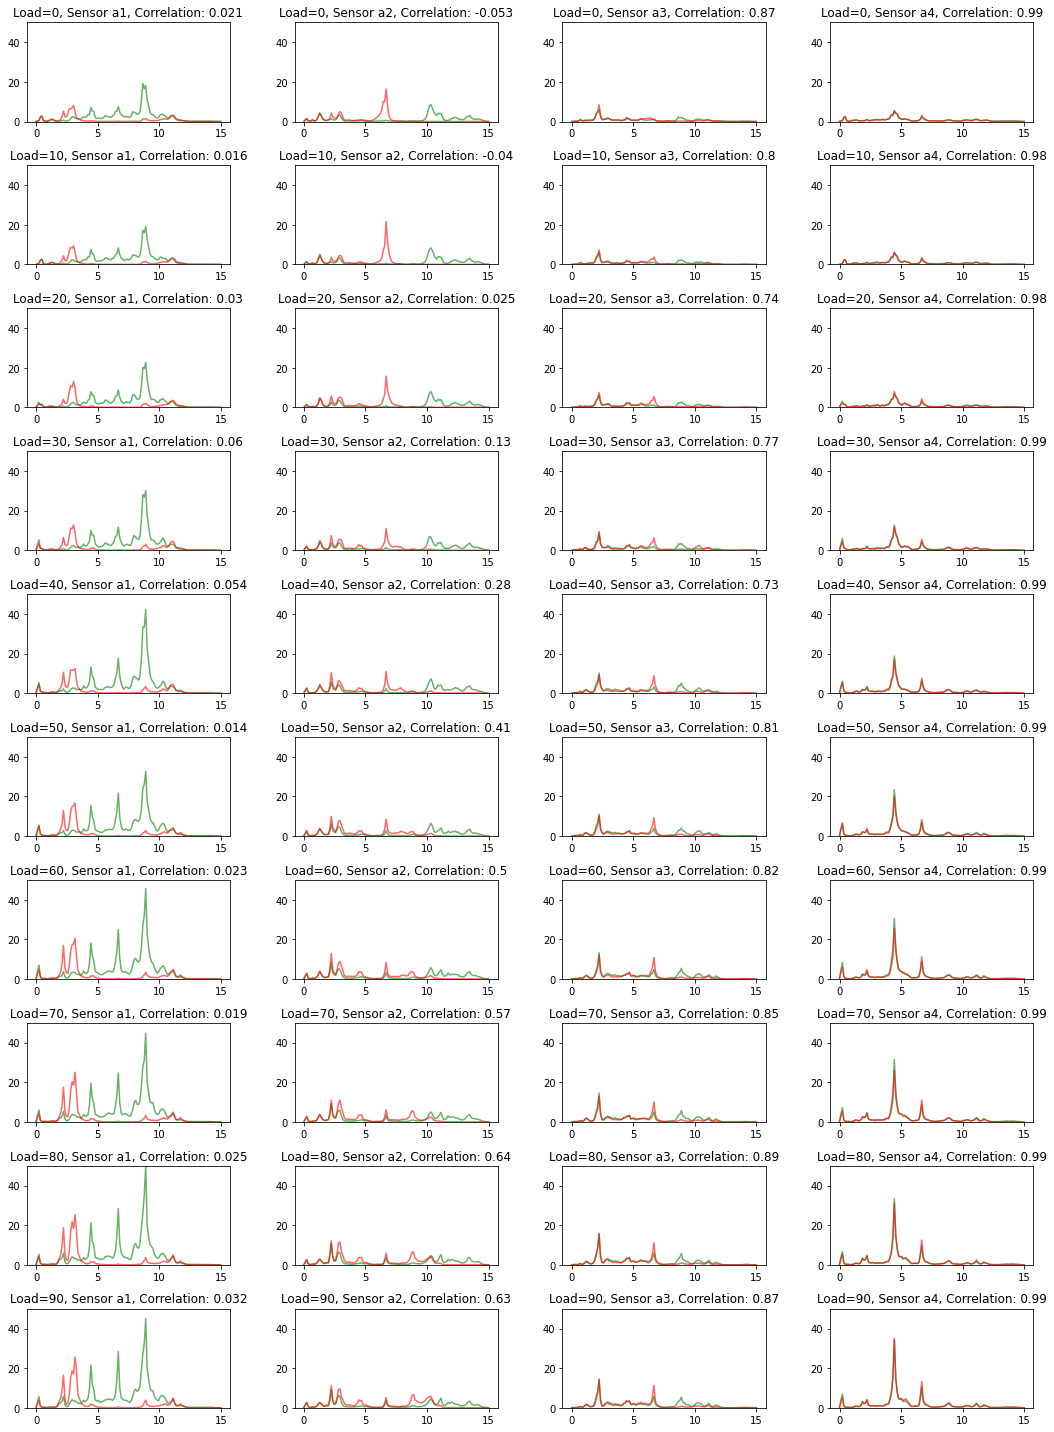

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=10, figsize=(15,20))
for ((load,sensor), dfg), axi in tqdm(zip(sensor_readings.groupby(['load','sensor']), ax.ravel()), total=40):
    healthy_raw = dfg[dfg.state=='h'].reading.values
    broken_raw = dfg[dfg.state=='b'].reading.values
    
    fh, Ph = signal.welch(healthy_raw, fs=30)
    fb, Pb = signal.welch(broken_raw, fs=30)

    axi.plot(fh, Ph, c='g', alpha=0.6)
    axi.plot(fb, Pb, c='r', alpha=0.6)
    axi.set_ylim(0,50)
    axi.set_title(f'Load={load}, Sensor {sensor}, Correlation: {np.corrcoef(Ph, Pb)[0,1]:0.2}')
plt.tight_layout()
plt.show()

  0%|          | 0/80 [00:00<?, ?it/s]

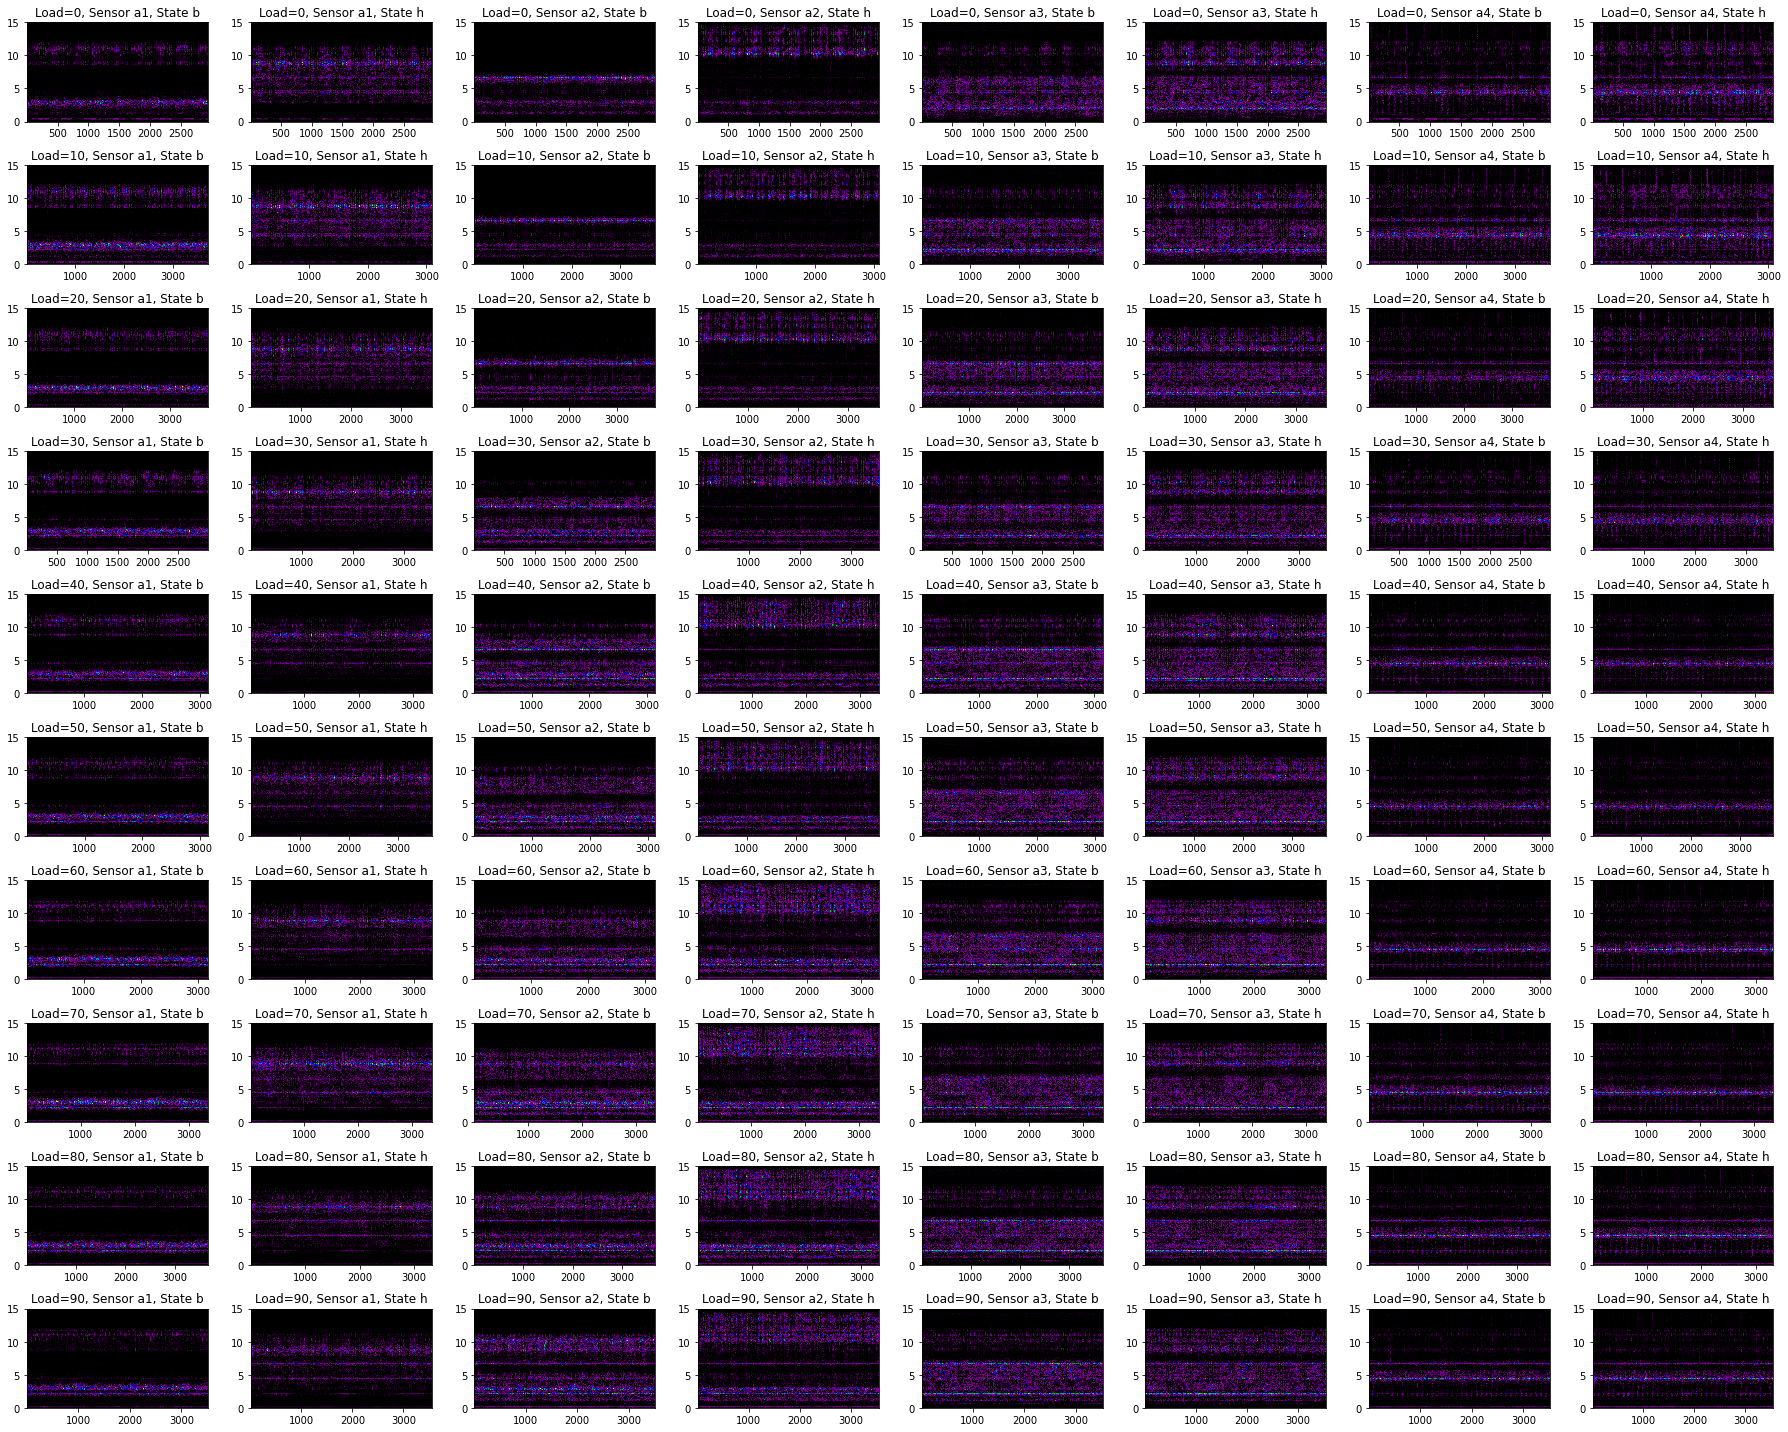

In [ ]:
fig, ax = plt.subplots(ncols=8, nrows=10, figsize=(25,20))
for ((load, sensor, state), dfg), axi in tqdm(zip(sensor_readings.groupby(['load','sensor','state']), ax.ravel()), total=80):
    raw = dfg.reading.values
    f, t, Sxx = signal.spectrogram(raw, fs=30)  # 30Hz data rate
    axi.pcolormesh(t, f, Sxx, cmap='nipy_spectral')
    axi.set_title(f'Load={load}, Sensor {sensor}, State {state}')
plt.tight_layout()
plt.show()

In [ ]:
data = []
labels = []
for (state,load,sensor),g in sensor_readings.groupby(['state','load','sensor']):
    vals = g.reading.values
    splits = np.split(vals, range(1000,vals.shape[0],1000))
    for s in splits[:-1]:  # except the last one
        data.append({
            'sensor_a1': int(sensor=='a1'),
            'sensor_a2': int(sensor=='a2'),
            'sensor_a3': int(sensor=='a3'),
            # no need to put a4: if a1-3 are 0, then it's sensor a4
            'load': load,
            'mean': np.mean(s),
            'std': np.std(s),
            'kurt': stats.kurtosis(s),
            'skew': stats.skew(s),
            'moment': stats.moment(s),
        })
        labels.append(int(state=='b'))  # positive label indicates fault

df_data = pd.DataFrame(data)
data = df_data.values
labels = np.array(labels)
(data.shape, labels.shape)

((8036, 9), (8036,))

In [ ]:
print(f'Total samples: {len(labels)}')
print(f'Fault class: {np.sum(labels)} ({np.sum(labels)/len(labels):0.1%})')

Total samples: 8036
Fault class: 4000 (49.8%)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data, labels,
    train_size=0.8,
    random_state=42,
    stratify=labels
)
print(f'Training data: {X_train.shape}')
print(f'Test data: {X_test.shape}')

Training data: (6428, 9)
Test data: (1608, 9)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
# tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
# features = tpot_data.drop('target', axis=1)
# training_features, testing_features, training_target, testing_target = \
            # train_test_split(features, tpot_data['target'], random_state=42)

# Average CV score on the training set was: 0.8699452348246002
exported_pipeline = ExtraTreesClassifier(bootstrap=True, criterion="entropy", max_features=0.6000000000000001, min_samples_leaf=13, min_samples_split=11, n_estimators=100)
# Fix random state in exported estimator
if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', 42)

exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_test)



In [ ]:

acc = sklearn.metrics.accuracy_score(np.array(y_test), 
                                     np.array(results))
acc

0.8638059701492538

In [ ]:
exported_pipeline

In [ ]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(exported_pipeline, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)
acc = sklearn.metrics.accuracy_score(np.array(y_test), 
                                     np.array(results))
acc

0.8638059701492538


0.8638059701492538

In [ ]:
%%time
# for i in range(10,30,5):
tpot_fd = TPOTClassifier(generations=2, random_state=42, max_time_mins=2)
tpot_fd.fit(X_train, y_train)
print(f'Best accuracy score: {tpot_fd.score(X_test, y_test):0.3%} for generation 2')
# Best accuracy score: 86.381%

Best accuracy score: 86.381% for generation 2
CPU times: user 2min 11s, sys: 46.9 s, total: 2min 58s
Wall time: 2min 8s


In [ ]:
%%time
tpot_fd.export('tpot_best_pipeline.py')


CPU times: user 661 µs, sys: 0 ns, total: 661 µs
Wall time: 672 µs


In [ ]:
y_pred = tpot_fd.predict(X_test)

In [ ]:
import sklearn
acc = sklearn.metrics.accuracy_score(np.array(y_test), 
                                     np.array(y_pred))
acc

0.8638059701492538

In [ ]:
acc

0.8638059701492538

In [ ]:
pd.Series([
    model.split('(')[0]
    for model
    in tpot_fd.evaluated_individuals_.keys()
]).value_counts()